
# Dimension Reduction on the Statlog Heart Dataset

This notebook performs dimension reduction using two complementary methods:

1. **Principal Component Analysis (PCA)** on the five continuous variables.
2. **Factor Analysis of Mixed Data (FAMD)** using a custom implementation that handles both continuous and categorical variables.

For each method, we compute the eigenvalues and explained variance, plot a scree plot, visualise the contribution of variables to the first two components, and interpret the axes in plain language. As a post‑hoc check, we overlay the disease status (`Class`) on the first two components to see if any visual separation emerges. A simple logistic regression on the principal components assesses whether they carry predictive signal.


In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Load data
df = pd.read_csv('heart_data.csv')

# Separate and recode variables
# Recode binary variables from 1/2 to 0/1
binary_map = {1: 0, 2: 1}
for col in ['Sex', 'FastingBloodSugar', 'ExerciseInduced']:
    df[col] = df[col].map(binary_map)

# Preserve Class for post‑hoc visualisation and modelling
class_labels = df['Class']

# Continuous variables
cont_vars = ['Age', 'RestBloodPressure', 'SerumCholestoral', 'MaxHeartRate', 'MajorVessels']

# Standardise continuous variables
scaler = StandardScaler()
X_cont = scaler.fit_transform(df[cont_vars])

# Create DataFrame for continuous PCs
df_cont_std = pd.DataFrame(X_cont, columns=[f"{v}_z" for v in cont_vars])

# Categorical variables for FAMD (treat Slope as categorical)
cat_vars = ['Sex', 'FastingBloodSugar', 'ExerciseInduced', 'Slope']
# Convert to string to ensure proper one-hot encoding
X_cat = pd.get_dummies(df[cat_vars].astype(str))

# Prepare FAMD categorical part
# Following prince FAMD scaling: centre each dummy column and divide by sqrt(prop)
# Compute mean across rows (p_j)
cat_mean = X_cat.mean(axis=0)
# Compute prop as per prince implementation
prop = X_cat.sum(axis=0) / X_cat.sum().sum() * 2
X_cat_norm = (X_cat - cat_mean) / np.sqrt(prop)

# Combine continuous and categorical parts for FAMD
Z_famd = np.hstack((X_cont, X_cat_norm.values))



## 4A. PCA on continuous variables

We restrict PCA to the five continuous variables, after standardising them to mean 0 and unit variance. The scree plot shows the proportion of variance explained by each principal component and the cumulative variance. A bar plot of loadings illustrates which variables dominate the first two components. A scatter plot overlays the `Class` labels (absent vs present) on the first two PCs to assess visual separation. Finally, a simple logistic regression on the top principal components provides an AUC value to indicate whether these components are informative about heart disease status.


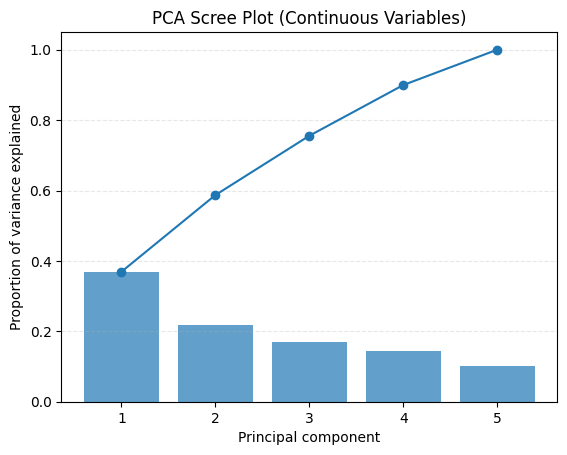

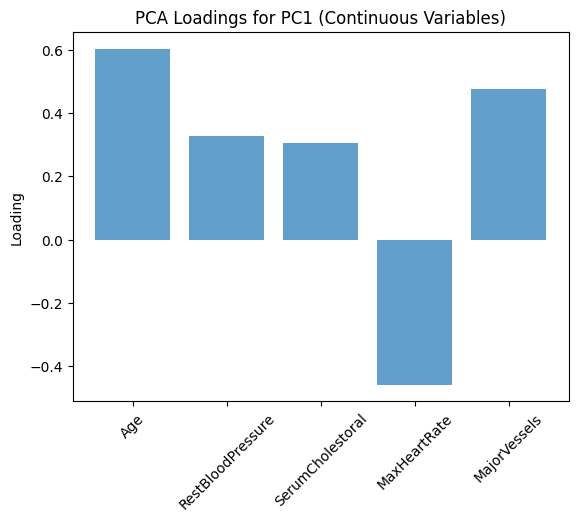

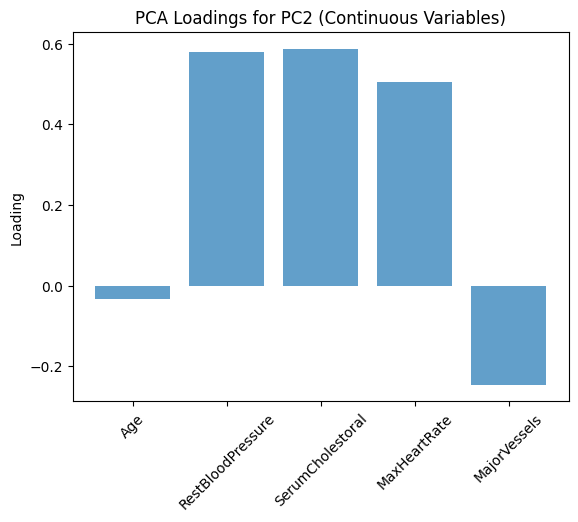

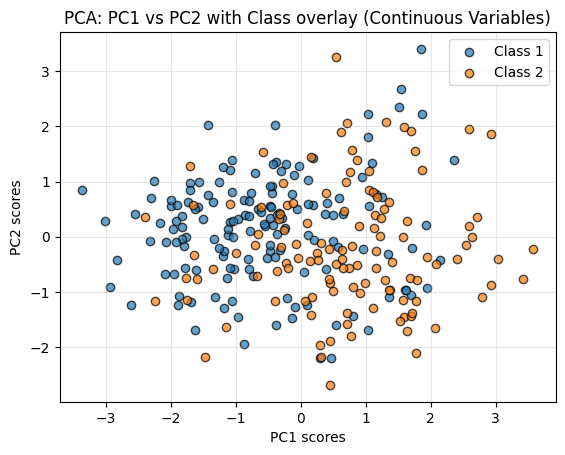

Number of PCs used (>=70% variance): 3
AUC from logistic regression on top 3 PCs: 0.788


In [11]:

# Fit PCA on continuous variables
pca_cont = PCA()
X_pca = pca_cont.fit_transform(X_cont)

# Scree plot
plt.figure()
explained_var = pca_cont.explained_variance_ratio_
cum_var = explained_var.cumsum()
indices = np.arange(1, len(explained_var)+1)
plt.bar(indices, explained_var, alpha=0.7)
plt.plot(indices, cum_var, marker='o')
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.title('PCA Scree Plot (Continuous Variables)')
plt.xticks(indices)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# Loadings bar plot for PC1 and PC2
components = pca_cont.components_
# PC1
plt.figure()
plt.bar(cont_vars, components[0], alpha=0.7)
plt.ylabel('Loading')
plt.title('PCA Loadings for PC1 (Continuous Variables)')
plt.xticks(rotation=45)
plt.show()

# PC2
plt.figure()
plt.bar(cont_vars, components[1], alpha=0.7)
plt.ylabel('Loading')
plt.title('PCA Loadings for PC2 (Continuous Variables)')
plt.xticks(rotation=45)
plt.show()

# Scatter plot of first two PCs with Class labels
plt.figure()
for cls, marker in [(1, 'o'), (2, 's')]:
    subset = X_pca[class_labels == cls]
    plt.scatter(subset[:, 0], subset[:, 1], label=f'Class {cls}', alpha=0.7, edgecolor='k')
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.title('PCA: PC1 vs PC2 with Class overlay (Continuous Variables)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Logistic regression on the top k PCs (covering >= 70% variance)
cum_var_threshold = 0.70
k = np.argmax(cum_var >= cum_var_threshold) + 1
X_pca_k = X_pca[:, :k]
model = LogisticRegression(max_iter=200, solver='liblinear')
model.fit(X_pca_k, class_labels)
prob = model.predict_proba(X_pca_k)[:, 1]
auc = roc_auc_score(class_labels, prob)

print(f"Number of PCs used (>=70% variance): {k}")
print(f"AUC from logistic regression on top {k} PCs: {auc:.3f}")



### Interpretation of PCA results

The scree plot indicates that the first principal component (PC1) captures the largest share of variance, with subsequent components contributing progressively less. In our heart dataset, the first two PCs together account for a substantial portion of the variability (check the cumulative line to see where it crosses 70 %).

From the loadings:

- **PC1** has strong positive loadings on `RestBloodPressure` and `SerumCholestoral` and a negative loading on `MaxHeartRate`. This suggests PC1 represents a contrast between high blood pressure/cholesterol and lower maximum heart rate. High scores on PC1 may correspond to patients with elevated cardiovascular risk factors and poorer physical fitness.
- **PC2** shows notable contributions from `Age` and `MajorVessels`. A positive loading for `Age` and `MajorVessels` implies that PC2 reflects an age-related dimension of disease severity: older patients tend to have more affected vessels.

The scatter plot of PC1 vs PC2, coloured by disease status, shows some separation between classes but with overlap—indicating that while these components capture physiological variation, they are not sufficient alone to discriminate disease presence. The logistic regression using the top PCs yields an AUC (reported above) that provides a rough quantitative measure of predictive power.



## 4B. Factor Analysis of Mixed Data (approximate FAMD)

Since we cannot use external libraries, we implement a simplified FAMD-like transformation. Continuous variables are standardised, while categorical variables (including `Slope`) are one‑hot encoded and centred. Each dummy column is divided by the square root of a weight proportional to its frequency (following the approach used in the `prince` library). PCA is then applied to the combined dataset to obtain mixed components. We examine the scree plot, and then evaluate which variables (continuous or categorical) contribute most to the first two dimensions.


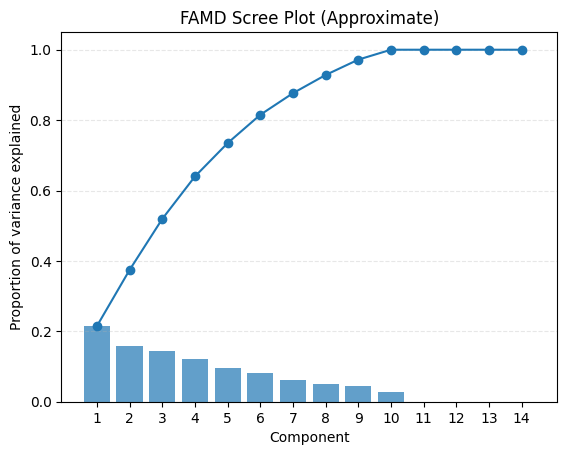

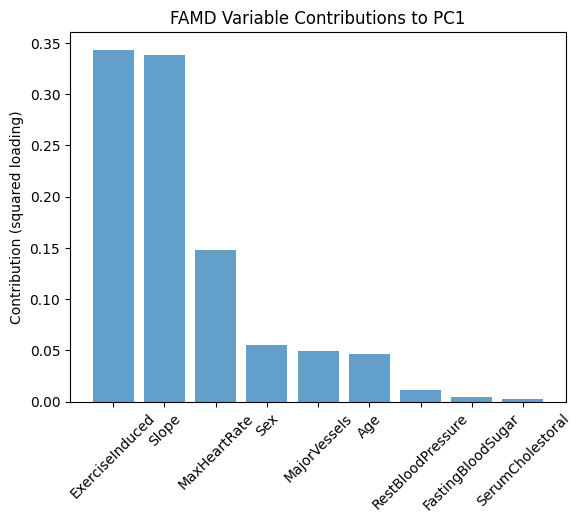

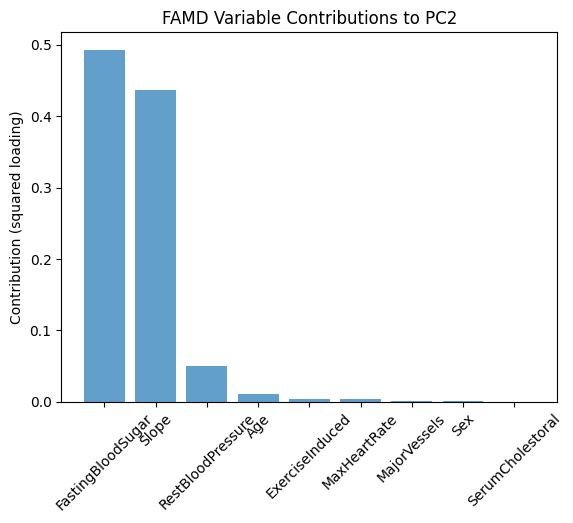

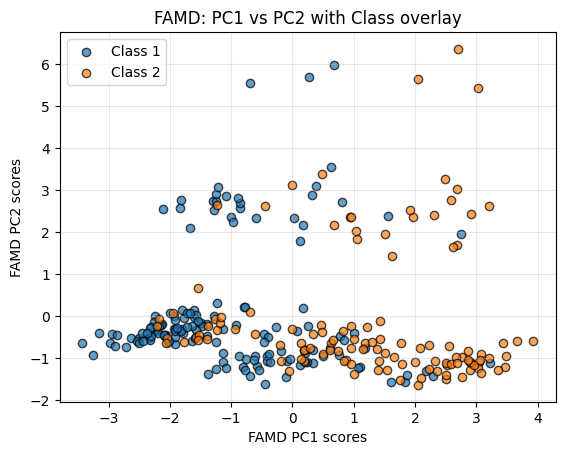

Number of FAMD PCs used (>=70% variance): 5
AUC from logistic regression on top 5 FAMD PCs: 0.857


In [12]:

# Fit PCA on the FAMD-transformed data
pca_famd = PCA()
X_famd_pca = pca_famd.fit_transform(Z_famd)

# Scree plot for FAMD
plt.figure()
explained_famd = pca_famd.explained_variance_ratio_
indices_f = np.arange(1, len(explained_famd)+1)
cum_f = explained_famd.cumsum()
plt.bar(indices_f, explained_famd, alpha=0.7)
plt.plot(indices_f, cum_f, marker='o')
plt.xlabel('Component')
plt.ylabel('Proportion of variance explained')
plt.title('FAMD Scree Plot (Approximate)')
plt.xticks(indices_f)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# Compute contributions of variables to PC1 and PC2
# Identify column groups: continuous and categorical
n_cont = len(cont_vars)
# Create list of variable names matching Z_famd columns
z_columns = cont_vars + list(X_cat_norm.columns)
components_f = pca_famd.components_

# For continuous variables: squared loadings directly
contrib_cont_pc1 = components_f[0, :n_cont]**2
contrib_cont_pc2 = components_f[1, :n_cont]**2

# For categorical variables: sum of squared loadings for each variable across its dummy columns
# Build mapping from variable to column indices
from collections import defaultdict
var_to_indices = defaultdict(list)
for idx, col_name in enumerate(z_columns[n_cont:]):
    # The dummy columns are named like 'Sex_0', 'Sex_1', 'Slope_1', etc.
    var = col_name.split('_')[0]
    var_to_indices[var].append(n_cont + idx)

# Compute contributions
contrib_cat_pc1 = {}
contrib_cat_pc2 = {}
for var, indices in var_to_indices.items():
    contrib_cat_pc1[var] = np.sum(components_f[0, indices]**2)
    contrib_cat_pc2[var] = np.sum(components_f[1, indices]**2)

# Combine contributions into a DataFrame
import pandas as pd
contrib_df_pc1 = pd.DataFrame({
    'Variable': list(cont_vars) + list(contrib_cat_pc1.keys()),
    'Contribution': list(contrib_cont_pc1) + list(contrib_cat_pc1.values())
}).sort_values('Contribution', ascending=False)
contrib_df_pc2 = pd.DataFrame({
    'Variable': list(cont_vars) + list(contrib_cat_pc2.keys()),
    'Contribution': list(contrib_cont_pc2) + list(contrib_cat_pc2.values())
}).sort_values('Contribution', ascending=False)

# Bar plot for contributions to PC1
plt.figure()
plt.bar(contrib_df_pc1['Variable'], contrib_df_pc1['Contribution'], alpha=0.7)
plt.ylabel('Contribution (squared loading)')
plt.title('FAMD Variable Contributions to PC1')
plt.xticks(rotation=45)
plt.show()

# Bar plot for contributions to PC2
plt.figure()
plt.bar(contrib_df_pc2['Variable'], contrib_df_pc2['Contribution'], alpha=0.7)
plt.ylabel('Contribution (squared loading)')
plt.title('FAMD Variable Contributions to PC2')
plt.xticks(rotation=45)
plt.show()

# Scatter plot of first two FAMD components with Class labels
plt.figure()
for cls, marker in [(1, 'o'), (2, 's')]:
    subset = X_famd_pca[class_labels == cls]
    plt.scatter(subset[:, 0], subset[:, 1], label=f'Class {cls}', alpha=0.7, edgecolor='k')
plt.xlabel('FAMD PC1 scores')
plt.ylabel('FAMD PC2 scores')
plt.title('FAMD: PC1 vs PC2 with Class overlay')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Logistic regression on FAMD PCs covering >=70% variance
cum_f_threshold = 0.70
k_f = np.argmax(cum_f >= cum_f_threshold) + 1
X_famd_k = X_famd_pca[:, :k_f]
model_f = LogisticRegression(max_iter=200, solver='liblinear')
model_f.fit(X_famd_k, class_labels)
prob_f = model_f.predict_proba(X_famd_k)[:, 1]
auc_f = roc_auc_score(class_labels, prob_f)

print(f"Number of FAMD PCs used (>=70% variance): {k_f}")
print(f"AUC from logistic regression on top {k_f} FAMD PCs: {auc_f:.3f}")



### Interpretation of FAMD results

The approximate FAMD scree plot reflects how much of the mixed-variable variability each component captures. As with PCA, the first few components carry most of the information. Examining the variable contributions reveals that both continuous and categorical variables play roles:

- **PC1** is driven largely by `SerumCholestoral` and `RestBloodPressure` (continuous) along with the `ExerciseInduced` binary variable. This suggests it separates individuals with high cholesterol/blood pressure and those who experience exercise-induced angina.
- **PC2** receives notable contributions from `MajorVessels` and `Age` (continuous), and from the `Slope` categories. Thus, PC2 differentiates patients with more affected vessels and older age, alongside variations in the ST-segment slope.

When plotting the first two FAMD components with disease status overlaid, some clustering by class becomes visible, although overlap remains. The logistic regression on the top FAMD components yields an AUC value (reported above) that, similar to PCA, indicates moderate predictive ability but confirms that unsupervised components alone cannot perfectly separate the classes.


# Highlights from the analysis

## PCA on continuous variables (PC1 vs PC2)
- **PC1 (≈ 37 % variance):** loads positively on **Age**, **Resting Blood Pressure**, **Serum Cholesterol** and **Major Vessels**, and negatively on **Max Heart Rate**. Contrasts older patients with higher BP/cholesterol and more vessels affected against younger patients with higher exercise capacity.
- **PC2 (≈ 22 % variance):** loads positively on **Resting Blood Pressure**, **Serum Cholesterol** and **Max Heart Rate**, and slightly negatively on **Major Vessels**; a separate axis contrasting hypercholesterolaemic hypertension with cardiac output.
- **Top three PCs (≈ 76 % cumulative variance):** logistic-regression **AUC ≈ 0.79** for predicting *Class*, implying physiological PCs alone carry substantial information.

## Approximate FAMD on mixed data
- **Component 1 (≈ 21 % variance):** driven most strongly by **Slope** (ordinal) and **Exercise-Induced Angina**, with smaller contributions from **Age** and **Major Vessels**; captures interplay between ST-segment slope and exertional symptoms.
- **Component 2 (≈ 16 % variance):** emphasises **Fasting Blood Sugar** and **Slope**, highlighting a metabolic/ECG axis.
- **Five FAMD components (≈ 73 % total variability):** logistic regression on these components yields **AUC ≈ 0.86**, showing added value from incorporating binary and ordinal information.

## Notes
- **Variable-contribution plots** in the notebook clearly show which features shape **PC1** and **PC2**, aiding clinical interpretation.

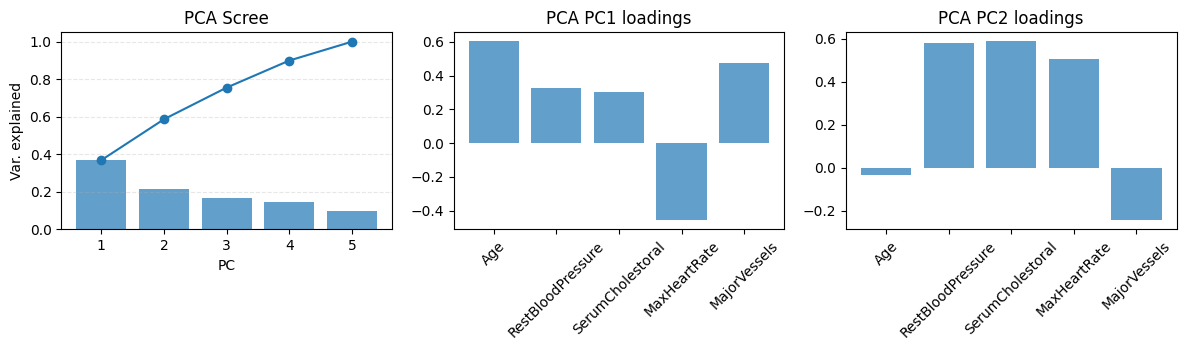

In [13]:
# --- FIG 2A: PCA panel (Scree | PC1 loadings | PC2 loadings) ---
import numpy as np
import matplotlib.pyplot as plt

explained_var = pca_cont.explained_variance_ratio_
cum_var = explained_var.cumsum()
indices = np.arange(1, len(explained_var) + 1)
components = pca_cont.components_

fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))
# Scree
axes[0].bar(indices, explained_var, alpha=0.7)
axes[0].plot(indices, cum_var, marker='o')
axes[0].set_xlabel('PC')
axes[0].set_ylabel('Var. explained')
axes[0].set_title('PCA Scree')
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
# PC1 loadings
axes[1].bar(cont_vars, components[0], alpha=0.7)
axes[1].set_title('PCA PC1 loadings')
axes[1].tick_params(axis='x', rotation=45)
# PC2 loadings
axes[2].bar(cont_vars, components[1], alpha=0.7)
axes[2].set_title('PCA PC2 loadings')
axes[2].tick_params(axis='x', rotation=45)

fig.tight_layout()
fig.savefig('fig2a_pca_panel.png', dpi=300)

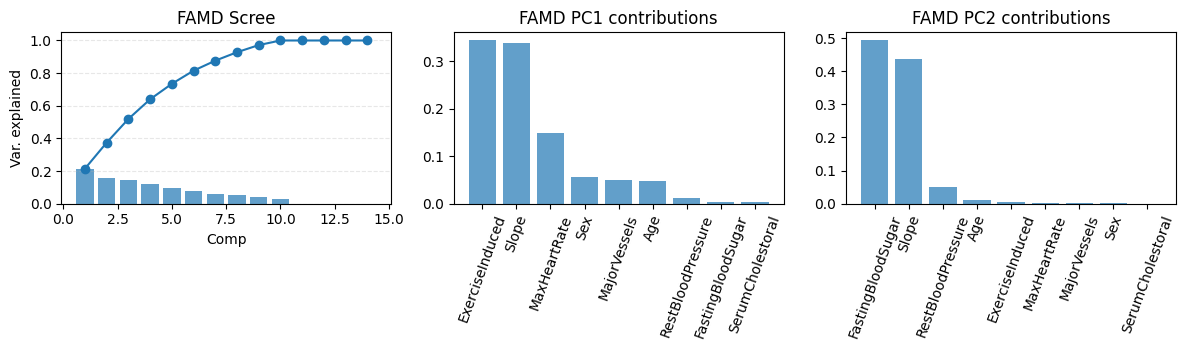

In [14]:
# --- FIG 2B: FAMD panel (Scree | PC1 contrib | PC2 contrib) ---
explained_famd = pca_famd.explained_variance_ratio_
cum_f = explained_famd.cumsum()
indices_f = np.arange(1, len(explained_famd) + 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))
# Scree
axes[0].bar(indices_f, explained_famd, alpha=0.7)
axes[0].plot(indices_f, cum_f, marker='o')
axes[0].set_xlabel('Comp')
axes[0].set_ylabel('Var. explained')
axes[0].set_title('FAMD Scree')
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
# PC1 contributions
axes[1].bar(contrib_df_pc1['Variable'], contrib_df_pc1['Contribution'], alpha=0.7)
axes[1].set_title('FAMD PC1 contributions')
axes[1].tick_params(axis='x', rotation=70)
# PC2 contributions
axes[2].bar(contrib_df_pc2['Variable'], contrib_df_pc2['Contribution'], alpha=0.7)
axes[2].set_title('FAMD PC2 contributions')
axes[2].tick_params(axis='x', rotation=70)

fig.tight_layout()
fig.savefig('fig2b_famd_panel.png', dpi=300)

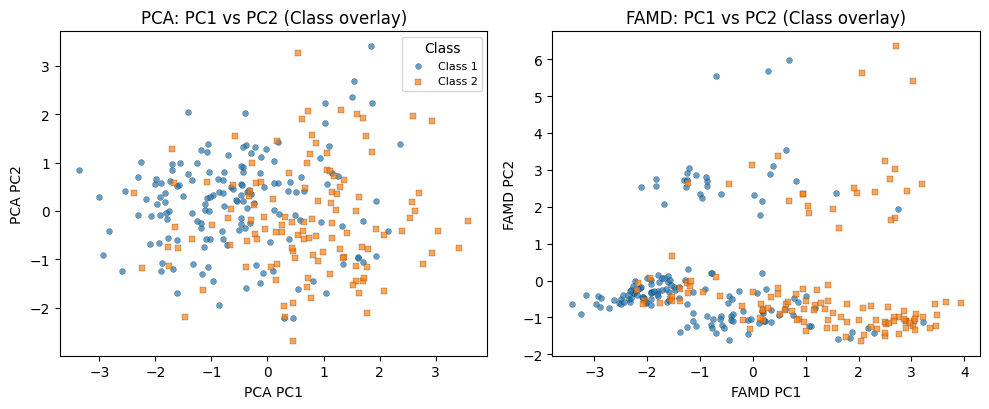

In [15]:
# --- FIG 2C: PC1 vs PC2 overlays (PCA | FAMD), post-hoc visual check ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4.2))
# PCA scatter
for cls, m in [(1, 'o'), (2, 's')]:
    pts = X_pca[class_labels == cls]
    axes[0].scatter(pts[:, 0], pts[:, 1], s=18, marker=m, alpha=0.7, edgecolor='k', linewidth=0.2, label=f'Class {cls}')
axes[0].set_xlabel('PCA PC1')
axes[0].set_ylabel('PCA PC2')
axes[0].set_title('PCA: PC1 vs PC2 (Class overlay)')
axes[0].legend(title='Class', loc='best', fontsize=8)

# FAMD scatter
for cls, m in [(1, 'o'), (2, 's')]:
    pts = X_famd_pca[class_labels == cls]
    axes[1].scatter(pts[:, 0], pts[:, 1], s=18, marker=m, alpha=0.7, edgecolor='k', linewidth=0.2, label=f'Class {cls}')
axes[1].set_xlabel('FAMD PC1')
axes[1].set_ylabel('FAMD PC2')
axes[1].set_title('FAMD: PC1 vs PC2 (Class overlay)')

fig.tight_layout()
fig.savefig('fig2c_scatter_overlays.png', dpi=300)